In [5]:
import tensorflow as tf
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from PIL import ImageFile
from PIL import Image, UnidentifiedImageError

# Allow loading of truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
NUM_CLASSES = 5
splits_dir = './splits'
dataset_path = './data'
class_names = ['Others', 'Honda', 'Suzuki', 'Yamaha', 'VinFast']


In [11]:

# Define the model building function
def build_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*IMG_SIZE, 3))
    base_model.trainable = False

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def validate_image(file_path):
    try:
        with Image.open(file_path) as img:
            img.verify()
        return True
    except (UnidentifiedImageError, IOError):
        print(f"Skipping invalid image: {file_path}")
        return False

def filter_invalid_images(df, directory):
    valid_indices = df['filename'].apply(lambda x: validate_image(os.path.join(directory, x)))
    return df[valid_indices]

def train_and_evaluate(train_csv, test_csv):
    # Data generators
    train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=40, width_shift_range=0.2,
                                       height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    # Read and filter the DataFrames
    train_df = pd.read_csv(train_csv, dtype={'label': str})
    test_df = pd.read_csv(test_csv, dtype={'label': str})

    train_df = filter_invalid_images(train_df, dataset_path)
    test_df = filter_invalid_images(test_df, dataset_path)

    train_generator = train_datagen.flow_from_dataframe(
        train_df,
        directory=dataset_path,
        x_col='filename',
        y_col='label',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )

    validation_generator = test_datagen.flow_from_dataframe(
        test_df,
        directory=dataset_path,
        x_col='filename',
        y_col='label',
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical'
    )

    steps_per_epoch = len(train_df) // BATCH_SIZE
    validation_steps = len(test_df) // BATCH_SIZE

    model = build_model()
    history = model.fit(
        train_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=10,  # Modify epochs as needed
        validation_data=validation_generator,
        validation_steps=validation_steps
    )

    # Plotting training and validation accuracy
    plt.figure()
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    plt.show()

    # Plotting training and validation loss
    plt.figure()
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.legend()
    plt.show()

Training and evaluating on ./splits/MotocycleDataset-Splits-1-Train.csv and ./splits/MotocycleDataset-Splits-1-Test.csv
Skipping invalid image: ./data/Others/22520968-22520996-22520999-22520929-22521373.Others.568.jpg
Found 2790 validated image filenames belonging to 5 classes.
Found 698 validated image filenames belonging to 5 classes.
Epoch 1/10


/home/tony/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/tony/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


174/174 ━━━━━━━━━━━━━━━━━━━━ 61s 335ms/step - accuracy: 0.2383 - loss: 1.8747 - val_accuracy: 0.2834 - val_loss: 1.5377
Epoch 2/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - accuracy: 0.3750 - loss: 1.5663 - val_accuracy: 0.4000 - val_loss: 1.5154
Epoch 3/10


2024-07-04 13:24:56.699435: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-07-04 13:24:56.796088: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


174/174 ━━━━━━━━━━━━━━━━━━━━ 59s 332ms/step - accuracy: 0.2811 - loss: 1.5518 - val_accuracy: 0.3561 - val_loss: 1.5087
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.3750 - loss: 1.4927 - val_accuracy: 0.5000 - val_loss: 1.3370
Epoch 5/10


2024-07-04 13:25:55.724470: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-04 13:25:55.824402: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


174/174 ━━━━━━━━━━━━━━━━━━━━ 58s 328ms/step - accuracy: 0.2964 - loss: 1.5304 - val_accuracy: 0.3474 - val_loss: 1.4865
Epoch 6/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - accuracy: 0.1250 - loss: 1.5116 - val_accuracy: 0.2000 - val_loss: 1.5416
Epoch 7/10


2024-07-04 13:26:54.313809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-04 13:26:54.413925: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


174/174 ━━━━━━━━━━━━━━━━━━━━ 58s 330ms/step - accuracy: 0.3070 - loss: 1.5108 - val_accuracy: 0.3358 - val_loss: 1.4680
Epoch 8/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - accuracy: 0.1875 - loss: 1.5468 - val_accuracy: 0.3000 - val_loss: 1.3928
Epoch 9/10


2024-07-04 13:27:53.027649: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-04 13:27:53.113919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


174/174 ━━━━━━━━━━━━━━━━━━━━ 59s 333ms/step - accuracy: 0.3091 - loss: 1.5112 - val_accuracy: 0.3343 - val_loss: 1.4747
Epoch 10/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - accuracy: 0.4375 - loss: 1.4426 - val_accuracy: 0.1000 - val_loss: 1.5200


2024-07-04 13:28:52.171033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-04 13:28:52.265185: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


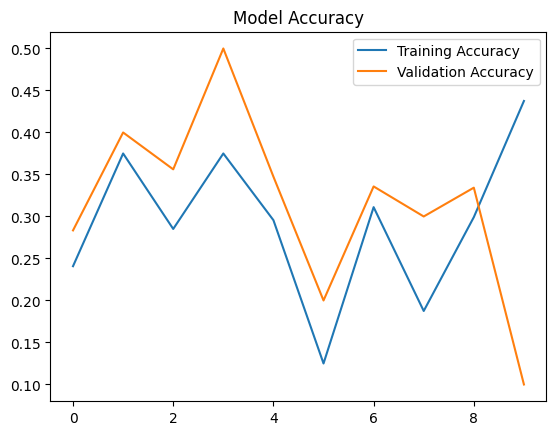

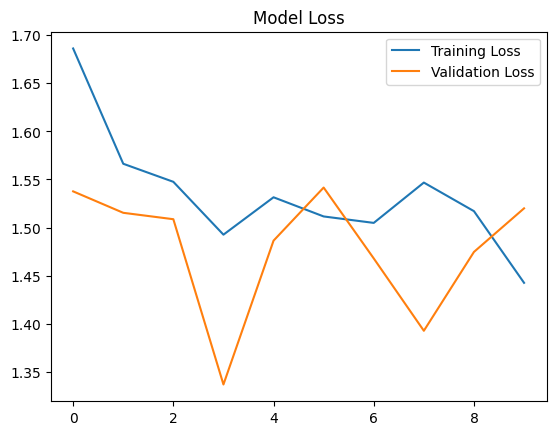

Training and evaluating on ./splits/MotocycleDataset-Splits-2-Train.csv and ./splits/MotocycleDataset-Splits-2-Test.csv
Found 2791 validated image filenames belonging to 5 classes.
Found 698 validated image filenames belonging to 5 classes.


/home/tony/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10


/home/tony/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


174/174 ━━━━━━━━━━━━━━━━━━━━ 61s 335ms/step - accuracy: 0.2657 - loss: 1.9426 - val_accuracy: 0.2762 - val_loss: 1.5257
Epoch 2/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.1250 - loss: 1.5889 - val_accuracy: 0.2000 - val_loss: 1.5424
Epoch 3/10


2024-07-04 13:29:54.937670: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-07-04 13:29:55.033539: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


174/174 ━━━━━━━━━━━━━━━━━━━━ 58s 330ms/step - accuracy: 0.2767 - loss: 1.5505 - val_accuracy: 0.2907 - val_loss: 1.5039
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - accuracy: 0.5000 - loss: 1.4458 - val_accuracy: 0.4000 - val_loss: 1.4749
Epoch 5/10


2024-07-04 13:30:53.693165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-04 13:30:53.788983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


174/174 ━━━━━━━━━━━━━━━━━━━━ 59s 333ms/step - accuracy: 0.2988 - loss: 1.5459 - val_accuracy: 0.2994 - val_loss: 1.5046
Epoch 6/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - accuracy: 0.0625 - loss: 1.6240 - val_accuracy: 0.2000 - val_loss: 1.5243
Epoch 7/10


2024-07-04 13:31:52.884548: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-04 13:31:52.975117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


174/174 ━━━━━━━━━━━━━━━━━━━━ 58s 325ms/step - accuracy: 0.3113 - loss: 1.5234 - val_accuracy: 0.3009 - val_loss: 1.4820
Epoch 8/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.3125 - loss: 1.4798 - val_accuracy: 0.0000e+00 - val_loss: 1.5982
Epoch 9/10


2024-07-04 13:32:51.050196: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-04 13:32:51.145522: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


174/174 ━━━━━━━━━━━━━━━━━━━━ 59s 331ms/step - accuracy: 0.3225 - loss: 1.5119 - val_accuracy: 0.2965 - val_loss: 1.4807
Epoch 10/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - accuracy: 0.1250 - loss: 1.4743 - val_accuracy: 0.4000 - val_loss: 1.5192


2024-07-04 13:33:49.929239: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-04 13:33:50.029270: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


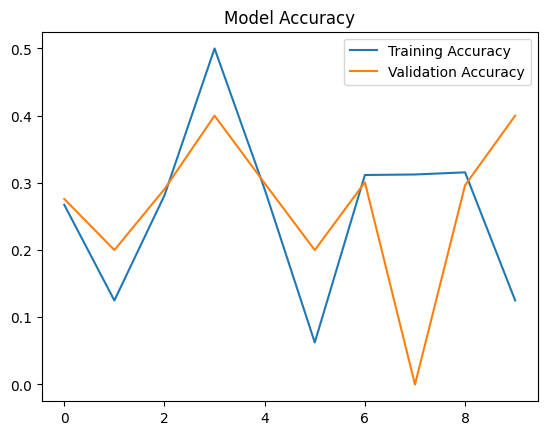

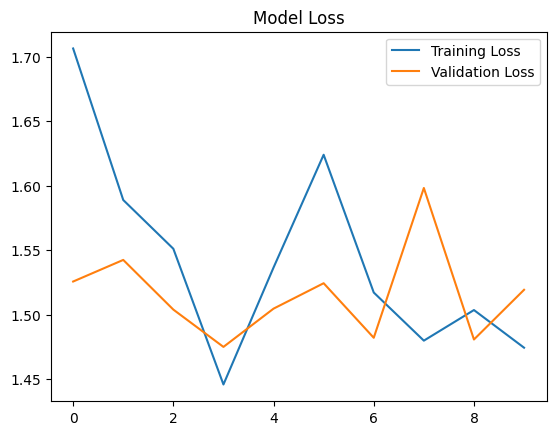

Training and evaluating on ./splits/MotocycleDataset-Splits-3-Train.csv and ./splits/MotocycleDataset-Splits-3-Test.csv
Skipping invalid image: ./data/Others/22520968-22520996-22520999-22520929-22521373.Others.567.jpg
Found 2790 validated image filenames belonging to 5 classes.
Found 697 validated image filenames belonging to 5 classes.


/home/tony/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10


/home/tony/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


174/174 ━━━━━━━━━━━━━━━━━━━━ 61s 335ms/step - accuracy: 0.2493 - loss: 1.9034 - val_accuracy: 0.2951 - val_loss: 1.5098
Epoch 2/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - accuracy: 0.3125 - loss: 1.5483 - val_accuracy: 0.2222 - val_loss: 1.5976
Epoch 3/10


2024-07-04 13:34:53.104751: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-07-04 13:34:53.188016: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


174/174 ━━━━━━━━━━━━━━━━━━━━ 58s 329ms/step - accuracy: 0.2768 - loss: 1.5577 - val_accuracy: 0.3358 - val_loss: 1.5118
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - accuracy: 0.3125 - loss: 1.7375 - val_accuracy: 0.2222 - val_loss: 1.4889
Epoch 5/10


2024-07-04 13:35:51.623664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-04 13:35:51.706768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


174/174 ━━━━━━━━━━━━━━━━━━━━ 58s 328ms/step - accuracy: 0.2772 - loss: 1.5456 - val_accuracy: 0.3183 - val_loss: 1.4909
Epoch 6/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - accuracy: 0.4375 - loss: 1.4778 - val_accuracy: 0.2222 - val_loss: 1.6610
Epoch 7/10


2024-07-04 13:36:49.893712: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-04 13:36:49.986126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


174/174 ━━━━━━━━━━━━━━━━━━━━ 58s 327ms/step - accuracy: 0.2859 - loss: 1.5243 - val_accuracy: 0.3648 - val_loss: 1.4658
Epoch 8/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - accuracy: 0.5000 - loss: 1.5505 - val_accuracy: 0.1111 - val_loss: 1.6299
Epoch 9/10


2024-07-04 13:37:48.134724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-04 13:37:48.221570: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


174/174 ━━━━━━━━━━━━━━━━━━━━ 58s 328ms/step - accuracy: 0.3095 - loss: 1.4891 - val_accuracy: 0.3430 - val_loss: 1.4782
Epoch 10/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - accuracy: 0.1250 - loss: 1.6204 - val_accuracy: 0.3333 - val_loss: 1.4324


2024-07-04 13:38:46.558432: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-04 13:38:46.646065: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


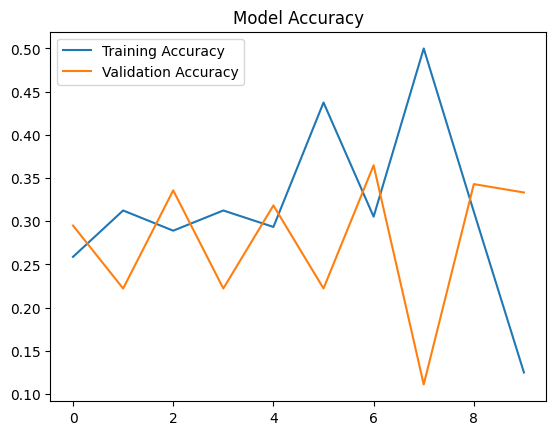

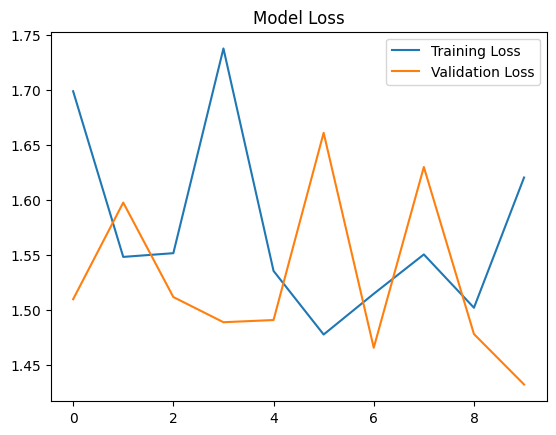

Training and evaluating on ./splits/MotocycleDataset-Splits-4-Train.csv and ./splits/MotocycleDataset-Splits-4-Test.csv
Skipping invalid image: ./data/VinFast/22520968-22520996-22520999-22520929-22521373.VinFast.313.jpg
Skipping invalid image: ./data/Others/22520968-22520996-22520999-22520929-22521373.Others.567.jpg
Found 2790 validated image filenames belonging to 5 classes.
Found 696 validated image filenames belonging to 5 classes.
Epoch 1/10


/home/tony/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/home/tony/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


174/174 ━━━━━━━━━━━━━━━━━━━━ 62s 340ms/step - accuracy: 0.2498 - loss: 1.8806 - val_accuracy: 0.3227 - val_loss: 1.5174
Epoch 2/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - accuracy: 0.2500 - loss: 1.6768 - val_accuracy: 0.3750 - val_loss: 1.4561
Epoch 3/10


2024-07-04 13:39:50.315625: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-07-04 13:39:50.390718: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


174/174 ━━━━━━━━━━━━━━━━━━━━ 60s 338ms/step - accuracy: 0.2719 - loss: 1.5758 - val_accuracy: 0.3445 - val_loss: 1.5050
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 593us/step - accuracy: 0.4375 - loss: 1.4645 - val_accuracy: 0.7500 - val_loss: 1.2504
Epoch 5/10


2024-07-04 13:40:50.420969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-04 13:40:50.490765: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


174/174 ━━━━━━━━━━━━━━━━━━━━ 60s 336ms/step - accuracy: 0.3156 - loss: 1.5260 - val_accuracy: 0.3517 - val_loss: 1.4677
Epoch 6/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - accuracy: 0.2500 - loss: 1.5344 - val_accuracy: 0.2500 - val_loss: 1.5802
Epoch 7/10


2024-07-04 13:41:50.259648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-04 13:41:50.330732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


174/174 ━━━━━━━━━━━━━━━━━━━━ 59s 335ms/step - accuracy: 0.3135 - loss: 1.5191 - val_accuracy: 0.3808 - val_loss: 1.4457
Epoch 8/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - accuracy: 0.1875 - loss: 1.4656 - val_accuracy: 0.2500 - val_loss: 1.6687
Epoch 9/10


2024-07-04 13:42:49.958497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-04 13:42:50.033352: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


174/174 ━━━━━━━━━━━━━━━━━━━━ 59s 335ms/step - accuracy: 0.3112 - loss: 1.5256 - val_accuracy: 0.3605 - val_loss: 1.4494
Epoch 10/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - accuracy: 0.1250 - loss: 1.5104 - val_accuracy: 0.5000 - val_loss: 1.2882


2024-07-04 13:43:49.526951: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-04 13:43:49.601454: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


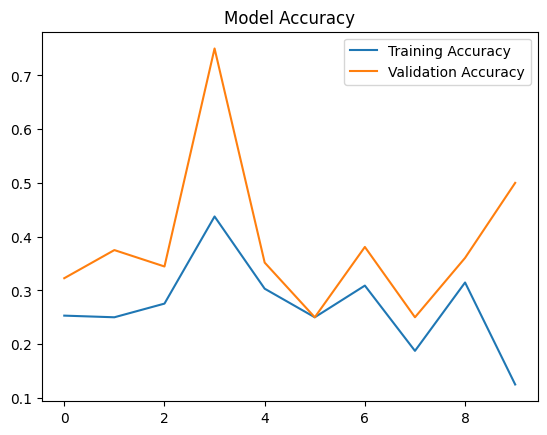

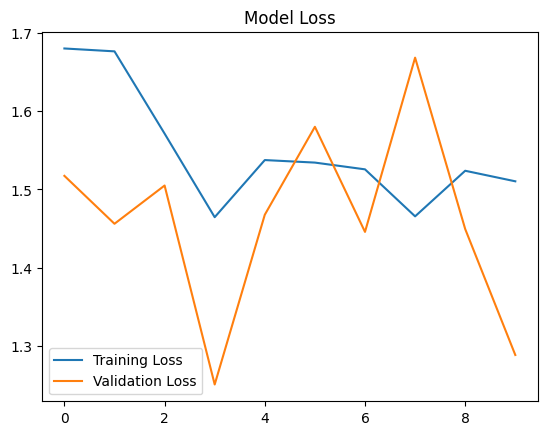

Training and evaluating on ./splits/MotocycleDataset-Splits-5-Train.csv and ./splits/MotocycleDataset-Splits-5-Test.csv
Skipping invalid image: ./data/VinFast/22520968-22520996-22520999-22520929-22521373.VinFast.311.jpg
Found 2790 validated image filenames belonging to 5 classes.
Found 697 validated image filenames belonging to 5 classes.
Epoch 1/10


/home/tony/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 14/174 ━━━━━━━━━━━━━━━━━━━━ 42s 264ms/step - accuracy: 0.1807 - loss: 2.2797

/home/tony/.local/lib/python3.10/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


174/174 ━━━━━━━━━━━━━━━━━━━━ 61s 333ms/step - accuracy: 0.2366 - loss: 1.8463 - val_accuracy: 0.2849 - val_loss: 1.5325
Epoch 2/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - accuracy: 0.3125 - loss: 1.5705 - val_accuracy: 0.2222 - val_loss: 1.4849
Epoch 3/10


2024-07-04 13:44:52.352320: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-07-04 13:44:52.443821: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


174/174 ━━━━━━━━━━━━━━━━━━━━ 59s 334ms/step - accuracy: 0.3034 - loss: 1.5407 - val_accuracy: 0.3052 - val_loss: 1.5117
Epoch 4/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - accuracy: 0.2500 - loss: 1.5280 - val_accuracy: 0.3333 - val_loss: 1.4331
Epoch 5/10


2024-07-04 13:45:51.686880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-04 13:45:51.766346: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


174/174 ━━━━━━━━━━━━━━━━━━━━ 59s 332ms/step - accuracy: 0.3161 - loss: 1.5151 - val_accuracy: 0.3343 - val_loss: 1.4904
Epoch 6/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - accuracy: 0.2500 - loss: 1.4763 - val_accuracy: 0.4444 - val_loss: 1.4896
Epoch 7/10


2024-07-04 13:46:50.676924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-04 13:46:50.757492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


174/174 ━━━━━━━━━━━━━━━━━━━━ 59s 332ms/step - accuracy: 0.3101 - loss: 1.5116 - val_accuracy: 0.3387 - val_loss: 1.4841
Epoch 8/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - accuracy: 0.2500 - loss: 1.5337 - val_accuracy: 0.4444 - val_loss: 1.4371
Epoch 9/10


2024-07-04 13:47:49.806728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-04 13:47:49.889712: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


174/174 ━━━━━━━━━━━━━━━━━━━━ 60s 337ms/step - accuracy: 0.3177 - loss: 1.5050 - val_accuracy: 0.3372 - val_loss: 1.4825
Epoch 10/10
174/174 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - accuracy: 0.3125 - loss: 1.5252 - val_accuracy: 0.0000e+00 - val_loss: 1.6689


2024-07-04 13:48:49.689969: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-07-04 13:48:49.777142: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


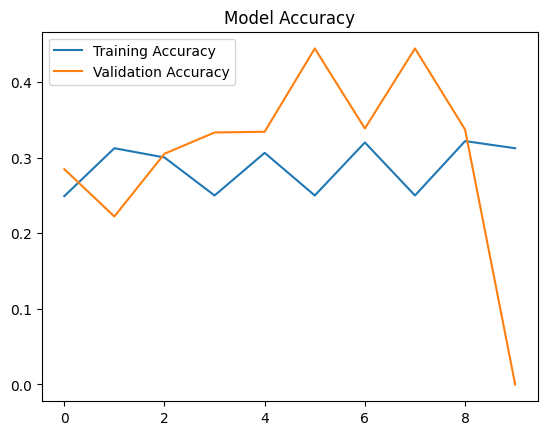

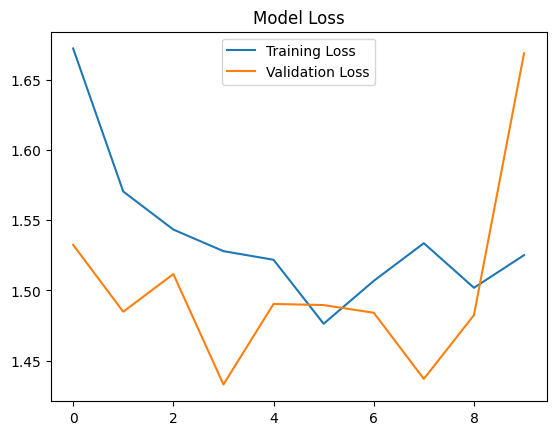

In [12]:
# Execute the training process for each fold
for i in range(1, 6):
    train_csv = os.path.join(splits_dir, f'MotocycleDataset-Splits-{i}-Train.csv')
    test_csv = os.path.join(splits_dir, f'MotocycleDataset-Splits-{i}-Test.csv')
    print(f"Training and evaluating on {train_csv} and {test_csv}")
    train_and_evaluate(train_csv, test_csv)